<h1 style='text-align: center;'>Customer churning</h1>

Dataset tomado de https://www.kaggle.com/sakshigoyal7/credit-card-customers

In [23]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
p = Path('.')
df = pd.read_csv(p / 'BankChurners.csv')

# Análisis exploratorio

In [3]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

Las últimas dos columnas (aparentemente) tienen resultados de un clasificador Naive Bayes, que no aporta en nada al proceso de predicción. Por lo tanto (y tal como se indica en el post del dataset), mejor eliminar las columnas.

In [3]:
df = df.drop(df.columns[-2:], axis=1)

## Datos faltantes

In [7]:
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

No hay datos faltantes.

In [46]:
categorical_features = df.select_dtypes('object').columns
discrete_features = df.select_dtypes('int64').columns
continuous_features = df.select_dtypes('float64').columns
numeric_features = np.concatenate((discrete_features, continuous_features))

# Wrangling

In [67]:
X = df.copy()
y = X.pop('Attrition_Flag')

In [70]:
cat_features = X.select_dtypes(['object'])
cat_features

Gender Education_Level Marital_Status Income_Category Card_Category
0          M     High School        Married     $60K - $80K          Blue
1          F        Graduate         Single  Less than $40K          Blue
2          M        Graduate        Married    $80K - $120K          Blue
3          F     High School        Unknown  Less than $40K          Blue
4          M      Uneducated        Married     $60K - $80K          Blue
...      ...             ...            ...             ...           ...
10122      M        Graduate         Single     $40K - $60K          Blue
10123      M         Unknown       Divorced     $40K - $60K          Blue
10124      F     High School        Married  Less than $40K          Blue
10125      M        Graduate        Unknown     $40K - $60K          Blue
10126      F        Graduate        Married  Less than $40K        Silver

[10127 rows x 5 columns]

In [75]:
cat_features.nunique().sort_values(ascending=False)

Education_Level    7
Income_Category    6
Card_Category      4
Marital_Status     4
Gender             2
dtype: int64

In [80]:
cat_features[cat_features=='Unknown'].count().sort_values(ascending=False)

Education_Level    1519
Income_Category    1112
Marital_Status      749
Card_Category         0
Gender                0
dtype: int64

In [5]:
def encode_card_category(X):
    card_categories = {
        'Blue': 0,
        'Silver': 1,
        'Gold': 2,
        'Platinum': 3
    }
    X['Card_Category'] = X['Card_Category'].apply(lambda x: card_categories[x])
    return X

def encode_income_category(X):
    income_categories = {
        'Unknown': 0,
        'Less than $40K': 1,
        '$40K - $60K': 2,
        '$60K - $80K': 3,
        '$80K - $120K': 4,
        '$120K +': 5
    }
    X['Income_Category'] = X['Income_Category'].apply(lambda x: income_categories[x])
    return X

def encode_education_level(X):
    education_levels = {
        'Unknown': 0,
        'Uneducated': 1,
        'High School': 2,
        'College': 3,
        'Graduate': 4,
        'Post-Graduate': 5,
        'Doctorate': 6
    }
    X['Education_Level'] = X['Education_Level'].apply(lambda x: education_levels[x])
    return X
    
def encode_ordinal_features(X):
    X = encode_card_category(X)
    X = encode_income_category(X)
    X = encode_education_level(X)
    return X

def encode_categorical_features(X):
    cat_features = ['Gender', 'Marital_Status']
    X[cat_features] = OrdinalEncoder().fit_transform(X[cat_features])
    return X

def encode_target(y):
    categories = {
        'Existing Customer': 0,
        'Attrited Customer': 1
    }
    y = y.apply(lambda x: categories[x])
    return y

def encoding(X, y):
    X = encode_ordinal_features(X)
    X = encode_categorical_features(X)
    y = encode_target(y)
    return X, y

In [115]:
X, y = encoding(X, y)

In [72]:
X.dtypes.value_counts()

int64      13
float64     5
dtype: int64

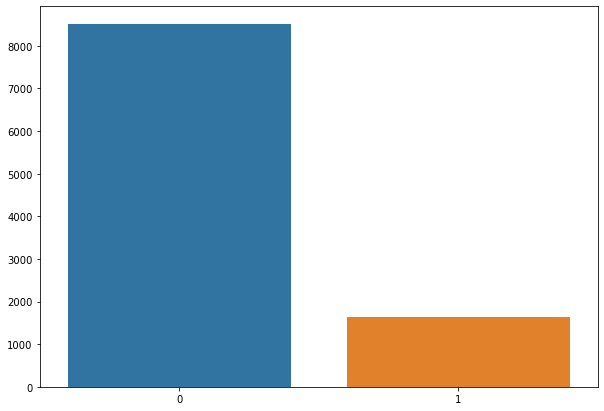

In [43]:
target_dist = pd.Series(y).value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=target_dist.index, y=target_dist.values)
plt.show()

# Análisis de features y feature engineering

Analizo las features y defino funciones para agregar features. Antes que esto, definiré una función para correr un modelo simple y evaluar qué tanto aportan las features que creo.

In [89]:
def score_dataset(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
    X_res, y_res = SMOTE().fit_resample(X_train, y_train)
    logit = LogisticRegression()
    logit.fit(X_res, y_res)
    preds = logit.predict(X_test)
    print(classification_report(y_test, preds))

In [90]:
score_dataset(X, y)

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      2583
           1       0.28      0.68      0.40       456

    accuracy                           0.70      3039
   macro avg       0.60      0.69      0.60      3039
weighted avg       0.83      0.70      0.74      3039



C:\Users\joaqu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
churning_clients_idx = y[y==1].index
churning_clients = X.iloc[churning_clients_idx]

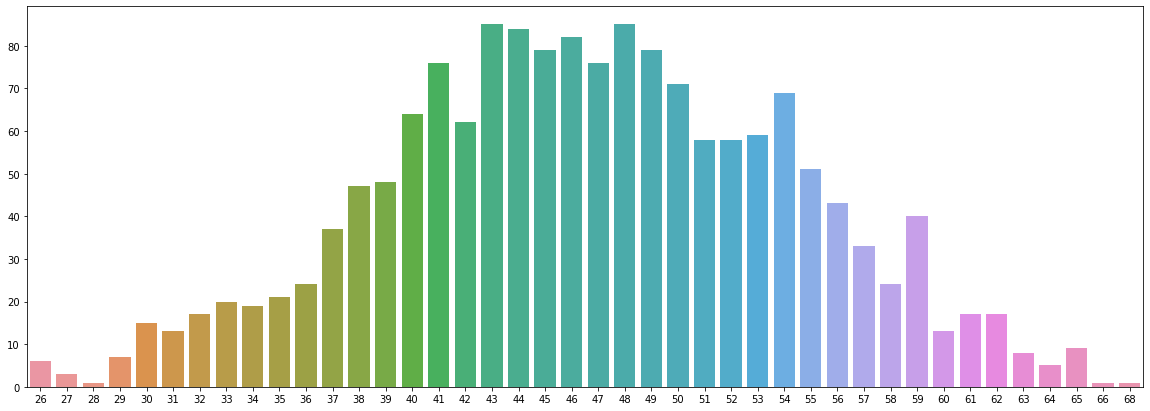

In [58]:
churning_clients_dist = churning_clients['Customer_Age'].value_counts()

plt.figure(figsize=(20,7))
sns.barplot(x=churning_clients_dist.index, y=churning_clients_dist.values)
plt.show()

In [6]:
def discretize_age(X):
    X['age_discrete'] = pd.cut(X['Customer_Age'], 4)
    X['age_discrete'] = LabelEncoder().fit_transform(X['age_discrete'])
    return X

X = df.copy()
y = X.pop('Attrition_Flag')
X, y = encoding(X, y)
X = discretize_age(X)

# score_dataset(X, y)

# Modelado

In [51]:
X = df.copy()
y = X.pop('Attrition_Flag')
X, y = encoding(X, y)
X = discretize_age(X)

X = X.drop('CLIENTNUM', axis=1)
numeric_features = np.delete(numeric_features, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True, stratify=y, random_state=0)
X_res, y_res = SMOTE().fit_resample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns=X_train.columns)



In [64]:
X_res_scaled = X_res.copy()
X_test_scaled = X_test.copy()

X_res_scaled = StandardScaler().fit_transform(X_res_scaled)
X_test_scaled = StandardScaler().fit_transform(X_test_scaled)

In [66]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0)
logit.fit(X_res, y_res)
logit_preds = logit.predict(X_test)
print(confusion_matrix(y_test, logit_preds))
print(classification_report(y_test, logit_preds))

C:\Users\joaqu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[2204  347]
 [ 100  388]]
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2551
           1       0.53      0.80      0.63       488

    accuracy                           0.85      3039
   macro avg       0.74      0.83      0.77      3039
weighted avg       0.89      0.85      0.86      3039



In [65]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0)
logit.fit(X_res_scaled, y_res)
logit_preds = logit.predict(X_test_scaled)
print(confusion_matrix(y_test, logit_preds))
print(classification_report(y_test, logit_preds))

[[1706  845]
 [  32  456]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      2551
           1       0.35      0.93      0.51       488

    accuracy                           0.71      3039
   macro avg       0.67      0.80      0.65      3039
weighted avg       0.88      0.71      0.75      3039



C:\Users\joaqu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [131]:
from sklearn.metrics import accuracy_score

In [145]:
random_forest = RandomForestClassifier(random_state=9)
random_forest.fit(X_res, y_res)

rf_preds = random_forest.predict(X_test)
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

C:\Users\joaqu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[2491   60]
 [ 133  355]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2551
           1       0.86      0.73      0.79       488

    accuracy                           0.94      3039
   macro avg       0.90      0.85      0.87      3039
weighted avg       0.93      0.94      0.93      3039



In [144]:
random_forest = RandomForestClassifier(random_state=9)
random_forest.fit(X_train, y_train)

rf_preds = random_forest.predict(X_test)
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

C:\Users\joaqu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[2521   30]
 [ 130  358]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2551
           1       0.92      0.73      0.82       488

    accuracy                           0.95      3039
   macro avg       0.94      0.86      0.89      3039
weighted avg       0.95      0.95      0.94      3039

